# Popular data science questions

## Introduction

The goal of this project is to determine what content should a data science education company create, based on interest by subject.

The website [Data Science Stack Exchange](https://datascience.stackexchange.com) is used to see what kind of content is more popular. This website is part of [Stack Exchange](https://en.wikipedia.org/wiki/Stack_Exchange), which is a network of question-and-answer websites on topics in diverse fields, each site covering a specific topic. Questions, answers and users are subject to a reputation award process, allowing the websites to be self-moderating. This award process gives us confidence in using Stack Exchange in our study.

The figure below exemplifies the tagging system used by DSSE, which allows us to quantify how many questions are asked about each subject. This information is used to assess what kind of content is more popular.

![tags_ds](https://dq-content.s3.amazonaws.com/469/tags_ds.png)

## Querying the data from DSSE

Stack Exchange provides an open-source tool named [Data Explorer](https://data.stackexchange.com/datascience/query/new) (SEDE), which is used for running arbitrary queries against public data from its network. SEDE uses a [Transact-SQL](https://en.wikipedia.org/wiki/Transact-SQL), which is Microsoft's and Sybase's proprietary extension to the SQL. This study will focus on table Posts, and in particular, on the following columns:

* Id - Identification number for the post.
* PostTypeId - Identification number for the type of post.
* CreationDate - The date and time of creation of the post.
* Score - The post's score.
* ViewCount - How many times the post was viewed.
* Tags - What tags were used.
* AnswerCount - How many answers the question got (only applicable to question posts).
* FavoriteCount - How many times the question was favored (only applicable to question posts).

The different types of post are:

1. Question
2. Answer
3. Wiki
4. TagWikiExcerpt
5. TagWiki
6. ModeratorNomination
7. WikiPlaceholder
8. PrivilegeWiki

To check the number of posts of each type, we run the following query:

```
SELECT PostTypeId, COUNT(*)
  FROM Posts
 GROUP BY PostTypeId;
```

which gives us

PostTypeId | Count
--- | ---
1 | 26285
2 | 29547
4 | 246
5 | 246
6 | 11
7 | 1

Questions and answers types of posts have a much higher volume than the remaining types of posts. This study will focus on the questions posts of 2019. We run the following query to get the data and after export it to the file `2019_questions.csv`.

```
SELECT Id, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount
  FROM Posts
 WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;
```

## Checking and cleaning the data

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from file
q_2019 = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])
q_2019

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN
...,...,...,...,...,...,...,...
8834,55413,2019-07-10 09:08:31,1,39,<pca><dimensionality-reduction><linear-algebra>,1,1.0
8835,55414,2019-07-10 09:34:55,0,113,<keras><weight-initialization>,0,NaN
8836,55415,2019-07-10 09:45:37,1,212,<python><visualization><seaborn>,1,NaN
8837,55416,2019-07-10 09:59:56,0,22,<time-series>,0,NaN


In [2]:
q_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             8839 non-null   int64         
 1   CreationDate   8839 non-null   datetime64[ns]
 2   Score          8839 non-null   int64         
 3   ViewCount      8839 non-null   int64         
 4   Tags           8839 non-null   object        
 5   AnswerCount    8839 non-null   int64         
 6   FavoriteCount  1407 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


Only the column `FavoriteCount` has missing values. Maybe a missing value represents a zero value. Let’s check if the value zero is also used.

In [3]:
(q_2019["FavoriteCount"] == 0).sum()

175

The value zero is also used, and so it is unclear what does a missing value means. Also, the number of missing values of the column `FavoriteCount` is very significant, and hence this column will be removed.

In [4]:
q_2019.drop("FavoriteCount", axis=1, inplace=True)

The values in the `Tags` column are strings that look like this:

"\<python>\<deep-learning>\<convnet>\<image-recognition>"

It is not easy to work with this format. We will convert each element into a list of tags.

In [5]:
q_2019["Tags"] = q_2019["Tags"].str.findall(r"<(.+?)>")

## Most popular tags

We will now determine the most popular tags. To do so, we will consider two different popularity proxies: for each tag we'll count how many times the tag was used, and how many times a question with that tag was viewed.

In [6]:
# Get the unique tags
tags = list(set([j for i in q_2019["Tags"] for j in i]))

# Calculate the number of times each tag was used and viewed
tags = pd.DataFrame(index=tags, columns=["used","viewed"])

def tag_popularity(row):

    is_used = q_2019["Tags"].apply(lambda x: True if row.name in x else False)
    
    row["used"] = is_used.sum()
    row["viewed"] = q_2019.loc[is_used, "ViewCount"].sum()
    
    return row

tags = tags.apply(tag_popularity, axis=1)

Let’s look at the ten most popular tags for both popularity proxies.

<AxesSubplot:title={'center':'N. of views'}>

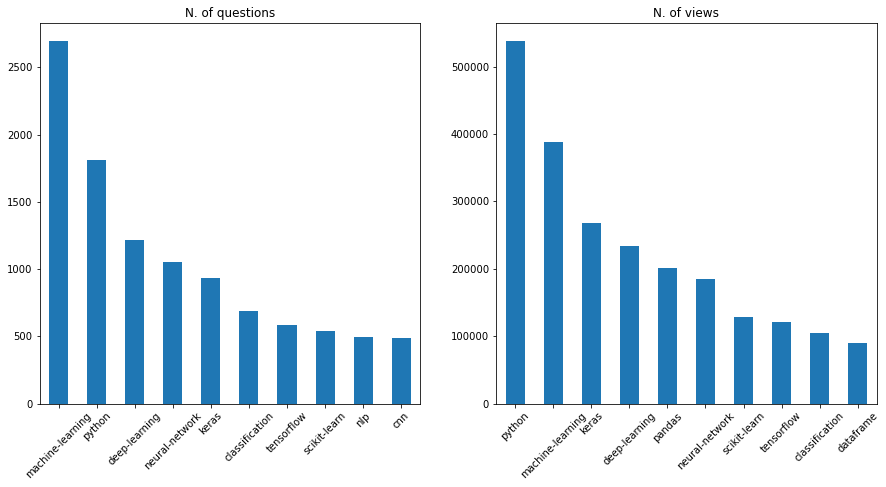

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
tags["used"].sort_values(ascending=False).head(10).plot.bar(ax=ax[0], title="N. of questions", rot=45)
tags["viewed"].sort_values(ascending=False).head(10).plot.bar(ax=ax[1], title="N. of views", rot=45)

The majority of the top 10 used tags also appear on the top 10 viewed tags. We will now consider only the tags that appear on both sets.

In [8]:
# Top 10 used tags
top_used_tags = tags["used"].sort_values(ascending=False).index[:10]

# Top 10 viewed tags
top_viewed_tags = tags["viewed"].sort_values(ascending=False).index[:10]

# Top tags
top_tags = sorted(list(set(top_used_tags) & set(top_viewed_tags)))
print(top_tags)

['classification', 'deep-learning', 'keras', 'machine-learning', 'neural-network', 'python', 'scikit-learn', 'tensorflow']


The tags descriptions listed below were taken from the [tags page](https://datascience.stackexchange.com/tags) on DSSE.

* classification - An instance of supervised learning that identifies the category or categories which a new instance of dataset belongs.
* deep-learning - A new area of Machine Learning research concerned with the technologies used for learning hierarchical representations of data, mainly done with deep neural networks but also with some sort of Probabilistic Graphical Models.
* keras - A minimalist, highly modular neural network library written in Python.
* machine-learning - Methods and principles of building "computer systems that automatically improve with experience."
* neural-network - Artificial neural networks (ANN), are composed of 'neurons' - programming constructs that mimic the properties of biological neurons. A set of weighted connections between the neurons allows information to propagate through the network to solve artificial intelligence problems without the network designer having had a model of a real system.
* python - Use for data science questions related to the programming language Python.
* scikit-learn - Scikit-learn is a Python module comprising of simple and efficient tool for machine learning, data mining and data analysis.
* tensorflow - TensorFlow is an open source library for machine learning and machine intelligence. TensorFlow uses data flow graphs with tensors flowing along edges.

The goal of this project is to determine what content should a data science education company create, based on interest by subject. We do not want to choose a subject that is too broad. Also, if we choose something too specific, it won’t be relevant to many people. Deep learning seems to be a good candidate. It is not too broad, and it is the third most used in questions and the forth with most views.

## Popularity of deep learning

Ideally, the content we decide to create will be the most useful for as long as possible. Is deep learning just a fad? To verify this, we will look at all of the questions ever asked on DSSE. Previously, we just looked at the year 2019. We run the following query to get the data and after export it to the file `all_questions.csv`.

```
SELECT Id, CreationDate, Tags
  FROM Posts
 WHERE PostTypeId = 1;
```

In [9]:
# Read the data from file
q_all = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])

# Convert the tags of each post into a list of tags
q_all["Tags"] = q_all["Tags"].str.findall(r"<(.+?)>")

The most popular tags that are directly related to deep learning are: `cnn`, `tensorflow`, `keras` and `deep-learning`.

In [10]:
deep_learning_tags = {"cnn", "tensorflow", "keras", "deep-learning"}

Let’s create a column that has the value true if the list of tags contains any deep learning tags and false otherwise.

In [11]:
q_all["Is_DL"] = q_all["Tags"].apply(lambda x: 1 if len(set(x) & deep_learning_tags) > 0 else 0)
q_all.sample(5)

,Id,CreationDate,Tags,Is_DL
19220,12937,2016-07-22 09:30:22,"[machine-learning, clustering, unsupervised-le...",0
2824,38294,2018-09-15 17:40:00,"[neural-network, keras, mlp]",1
1521,25053,2017-11-23 14:40:25,"[nlp, clustering, word2vec, similarity]",0
16522,23618,2017-10-08 17:34:17,"[tensorflow, numerical]",1
13204,30628,2018-04-21 23:42:51,"[machine-learning, data-mining, clustering, da...",0


Now we will evaluate how the popularity of deep learning evolves with time. To avoid having too much variability of the results, we will group them by quarter. Since we don't have all the data for the first quarter of 2020, we'll get rid of those dates.

In [12]:
q_all = q_all[q_all["CreationDate"].dt.year < 2020]

def get_quarter(datetime):
    
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month - 1) // 3) + 1)
    
    return "{y}Q{q}".format(y=year, q=quarter)

q_all["Quarter"] = q_all["CreationDate"].apply(get_quarter)
q_all.sample(5)

,Id,CreationDate,Tags,Is_DL,Quarter
10268,19545,2017-06-08 04:31:04,"[neural-network, deep-learning, keras]",1,17Q2
7666,6440,2015-07-12 19:08:38,"[deep-learning, multitask-learning]",1,15Q3
18627,12622,2016-07-06 04:49:45,"[machine-learning, classification, naive-bayes...",0,16Q3
10794,9063,2015-11-26 13:07:02,"[machine-learning, data-mining, nlp, parsing]",0,15Q4
5702,26996,2018-01-24 12:42:29,"[machine-learning, tensorflow, keras, rnn, lstm]",1,18Q1


For each quarter we will:

* Count the number of deep learning questions.
* Count the total number of questions.
* Compute the ratio between the two numbers above.

In [13]:
quarterly = q_all.groupby('Quarter').agg({"Is_DL": ['sum', 'size']})

quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']

quarterly["DeepLearningRate"] = quarterly["DeepLearningQuestions"] /quarterly["TotalQuestions"]

quarterly.reset_index(inplace=True)

C:\PortablePrograms\WinPython\python-3.8.5.amd64\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


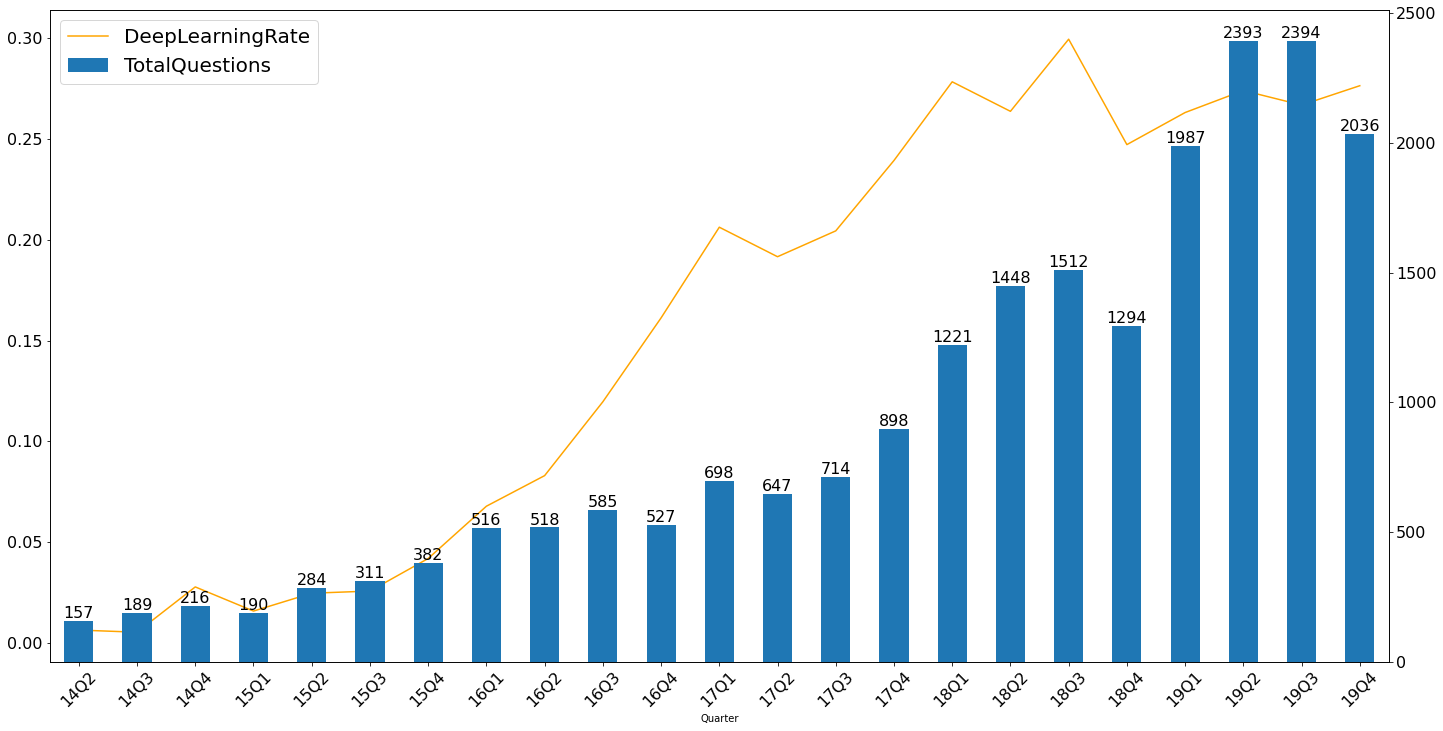

In [14]:
ax1 = quarterly.plot(x="Quarter", y="DeepLearningRate", color="orange", fontsize=16, figsize=(24,12))

ax2 = quarterly.plot.bar("Quarter", "TotalQuestions", ax=ax1, secondary_y=True, fontsize=16, rot=45)

for idx, val in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, val, str(val), fontsize=16, ha="center", va="bottom")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.get_legend().remove()
ax1.legend(h1 + h2, l1 + l2, loc='upper left', prop={"size": 20});

The popularity of deep learning had a significant growth between the second quarter of 2014 and the end of 2017. By the end of this year, almost 30% of all questions were related to deep learning. During 2018 and 2019, the popularity varied between 25% and 30%. Hence, we recommend that the data science education company should create content related to deep learning.